In [1]:
IS_LOCAL = False
import numpy as np
import pandas as pd
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
if(IS_LOCAL):
    import pydicom as dicom
else:
    import pydicom
import os
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
if(IS_LOCAL):
    PATH="../input/siim-medical-image/"
else:
    PATH="../Desktop/"
print(os.listdir(PATH))

In [ ]:
def process_data(path):
    data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+path)])
    data['file'] = data['path'].map(os.path.basename)
    data['ID'] = data['file'].map(lambda x: str(x.split('_')[1]))
    data['Age'] = data['file'].map(lambda x: int(x.split('_')[3]))
    data['Contrast'] = data['file'].map(lambda x: bool(int(x.split('_')[5])))
    data['Modality'] = data['file'].map(lambda x: str(x.split('_')[6].split('.')[-2]))
    return data

In [ ]:
print("Number of DICOM files:", len(os.listdir(PATH+"dicom_dir")))

In [5]:
dicom_data = process_data('dicom_dir/*.dcm')

In [6]:
dicom_data.head(10)

,path,file,ID,Age,Contrast,Modality
0,../nbs/dicom_dir\ID_0000_AGE_0060_CONTRAST_1_C...,ID_0000_AGE_0060_CONTRAST_1_CT.dcm,0000,60,True,CT
1,../nbs/dicom_dir\ID_0001_AGE_0069_CONTRAST_1_C...,ID_0001_AGE_0069_CONTRAST_1_CT.dcm,0001,69,True,CT
2,../nbs/dicom_dir\ID_0002_AGE_0074_CONTRAST_1_C...,ID_0002_AGE_0074_CONTRAST_1_CT.dcm,0002,74,True,CT
3,../nbs/dicom_dir\ID_0003_AGE_0075_CONTRAST_1_C...,ID_0003_AGE_0075_CONTRAST_1_CT.dcm,0003,75,True,CT
4,../nbs/dicom_dir\ID_0004_AGE_0056_CONTRAST_1_C...,ID_0004_AGE_0056_CONTRAST_1_CT.dcm,0004,56,True,CT
5,../nbs/dicom_dir\ID_0005_AGE_0048_CONTRAST_1_C...,ID_0005_AGE_0048_CONTRAST_1_CT.dcm,0005,48,True,CT
6,../nbs/dicom_dir\ID_0007_AGE_0061_CONTRAST_1_C...,ID_0007_AGE_0061_CONTRAST_1_CT.dcm,0007,61,True,CT
7,../nbs/dicom_dir\ID_0008_AGE_0051_CONTRAST_1_C...,ID_0008_AGE_0051_CONTRAST_1_CT.dcm,0008,51,True,CT
8,../nbs/dicom_dir\ID_0009_AGE_0048_CONTRAST_1_C...,ID_0009_AGE_0048_CONTRAST_1_CT.dcm,0009,48,True,CT


In [7]:
def show_images(data,dim=16):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(2,4,figsize=(16,20))
    for i,data_row in enumerate(img_data):
        data_row_img = pydicom.read_file(data_row['path'])
        ax[i//4, i%4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast} '.format(**data_row))
    plt.show()

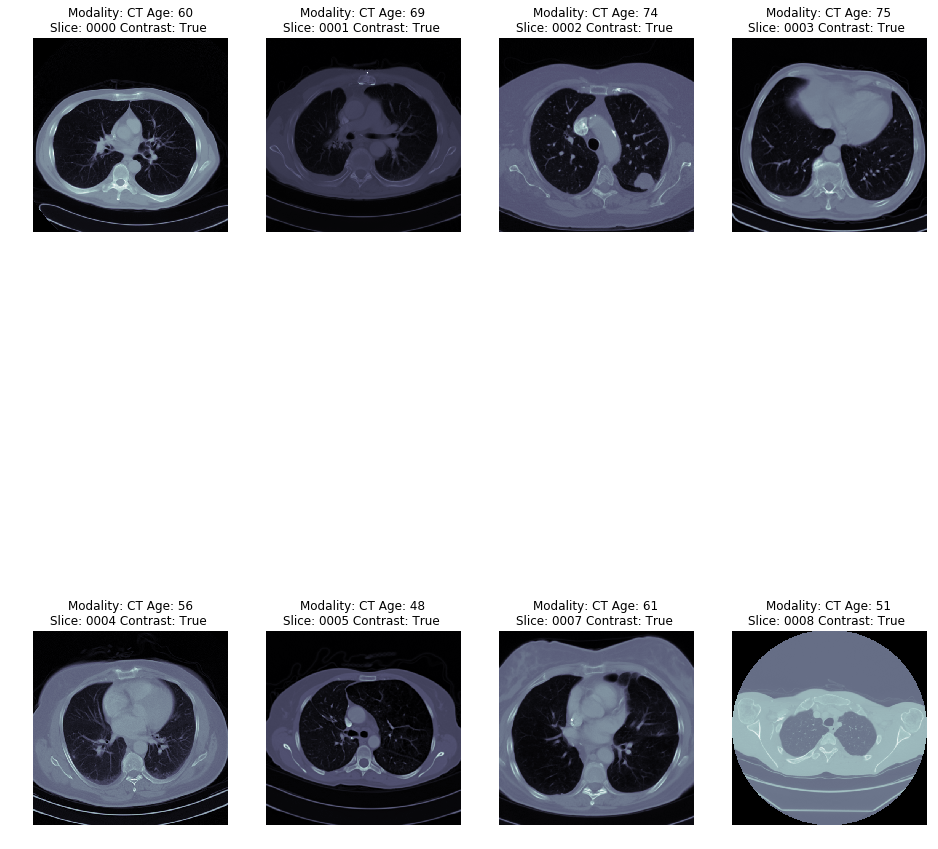

In [8]:
show_images(dicom_data,8)

In [56]:
def show_images(data,mode,dim=16):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(2,4,figsize=(16,20))
    for i,data_row in enumerate(img_data):
        data_row_img = pydicom.read_file(data_row['path'])
        img=data_row_img.pixel_array.astype('float32')
        if mode==1:
            p=cv2.GaussianBlur(img,(5,5),0)
        elif mode==2:
            p=cv2.blur(img,(5,5))
        elif mode==3:
            p=cv2.medianBlur(img,5)
        elif mode==4:
            p=cv2.bilateralFilter(img,9,75,75)
        elif mode==5:
            p=cv2.GaussianBlur(img,(5,5),0)
            p=cv2.medianBlur(p,5)
        elif mode==6:
            p=cv2.blur(img,(5,5))
            p=cv2.bilateralFilter(p,9,75,75)
        ax[i//4, i%4].imshow(p, cmap=plt.cm.bone) 
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast} '.format(**data_row))
    plt.show()


In [57]:
print("Choice\n1.Gaussian Blur\n2.Blur\n3.Median Blur\n4.Bilateral\n5.Gaussian + Median\n6.Blur+ Bilateral")

Choice
1.Gaussian Blur
2.Blur
3.Median Blur
4.Bilateral
5.Gaussian + Median
6.Blur+ Bilateral


enter3


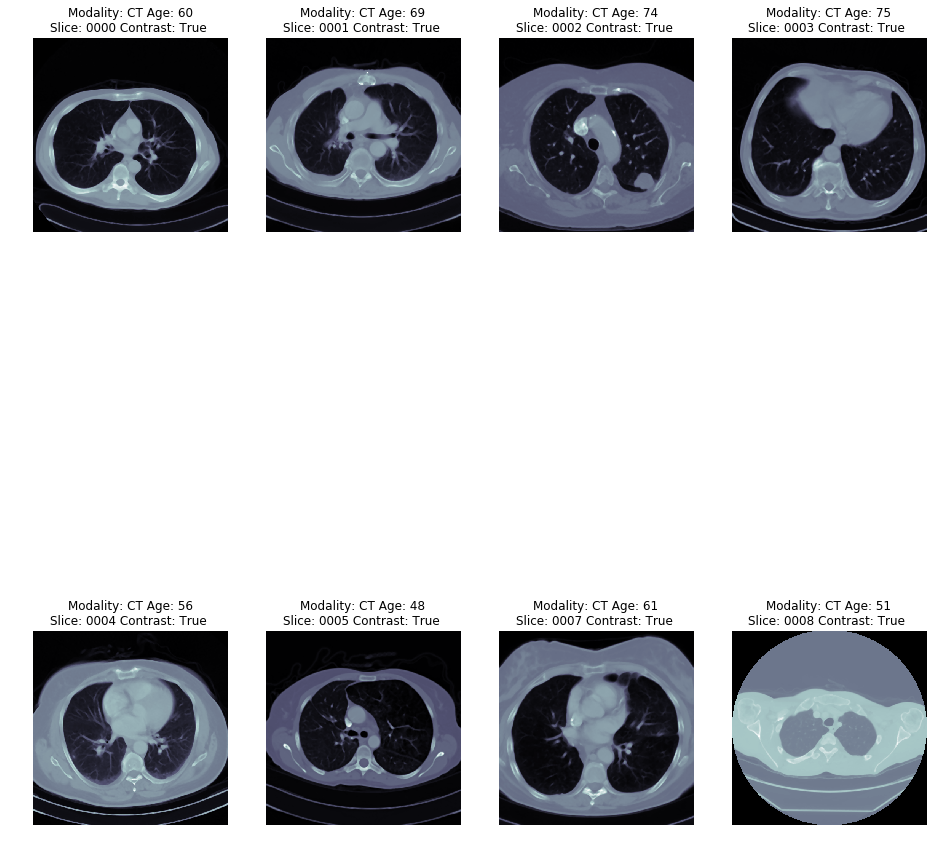

In [58]:
inp=int(input("enter"))
show_images(dicom_data,inp,8)

In [11]:
def segement(data,dim=16):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4,4,figsize=(16,20))
    for i,data_row in enumerate(img_data):
        data_row_img = pydicom.read_file(data_row['path'])
        img=data_row_img.pixel_array.astype('uint8')
        np.place(img, img>255, [255.])
        ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        ax[(i//4)*2, i%4].imshow(thresh, cmap=plt.cm.bone)
        ax[(i//4)*2, i%4].axis('off')
        ax[(i//4)*2, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast} '.format(**data_row))
        
        data_row_img = pydicom.read_file(data_row['path'])
        img=data_row_img.pixel_array.astype('float32')
        ax[(i//4)*2+1, (i)%4].imshow(img, cmap=plt.cm.bone)
        ax[(i//4)*2+1, (i)%4].axis('off')
        ax[(i//4)*2+1, (i)%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast} '.format(**data_row))
        
    plt.show()


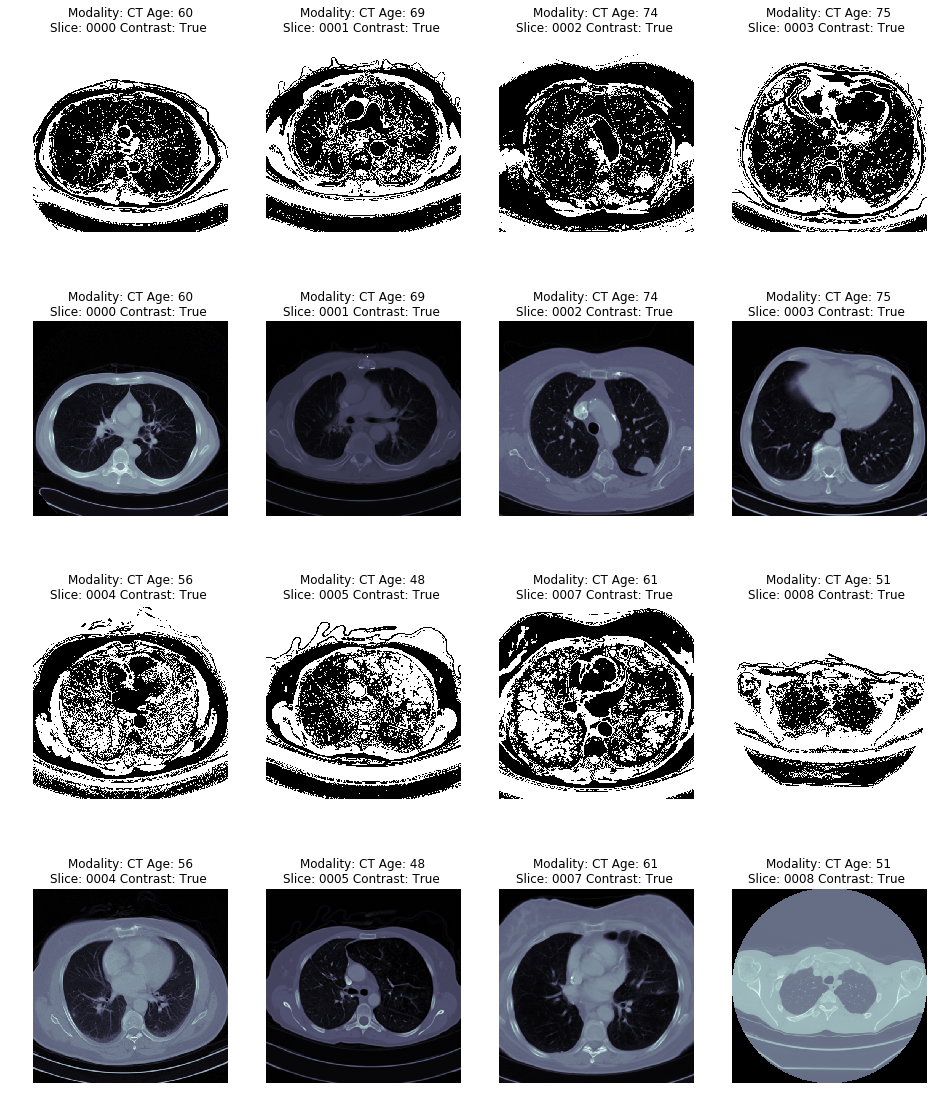

In [12]:
segement(dicom_data,8)

In [13]:
def segementH(data,dim=16):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4,4,figsize=(16,20))
    for i,data_row in enumerate(img_data):
        data_row_img = pydicom.read_file(data_row['path'])
        img=data_row_img.pixel_array.astype('uint8')
        np.place(img, img>255, [255.])
        ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # Further noise removal
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        ax[(i//4)*2, i%4].imshow(sure_bg, cmap=plt.cm.bone)
        ax[(i//4)*2, i%4].axis('off')
        ax[(i//4)*2, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast} '.format(**data_row))
        
        data_row_img = pydicom.read_file(data_row['path'])
        img=data_row_img.pixel_array.astype('float32')
        ax[(i//4)*2+1, (i)%4].imshow(img, cmap=plt.cm.bone)
        ax[(i//4)*2+1, (i)%4].axis('off')
        ax[(i//4)*2+1, (i)%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast} '.format(**data_row))
        
    plt.show()


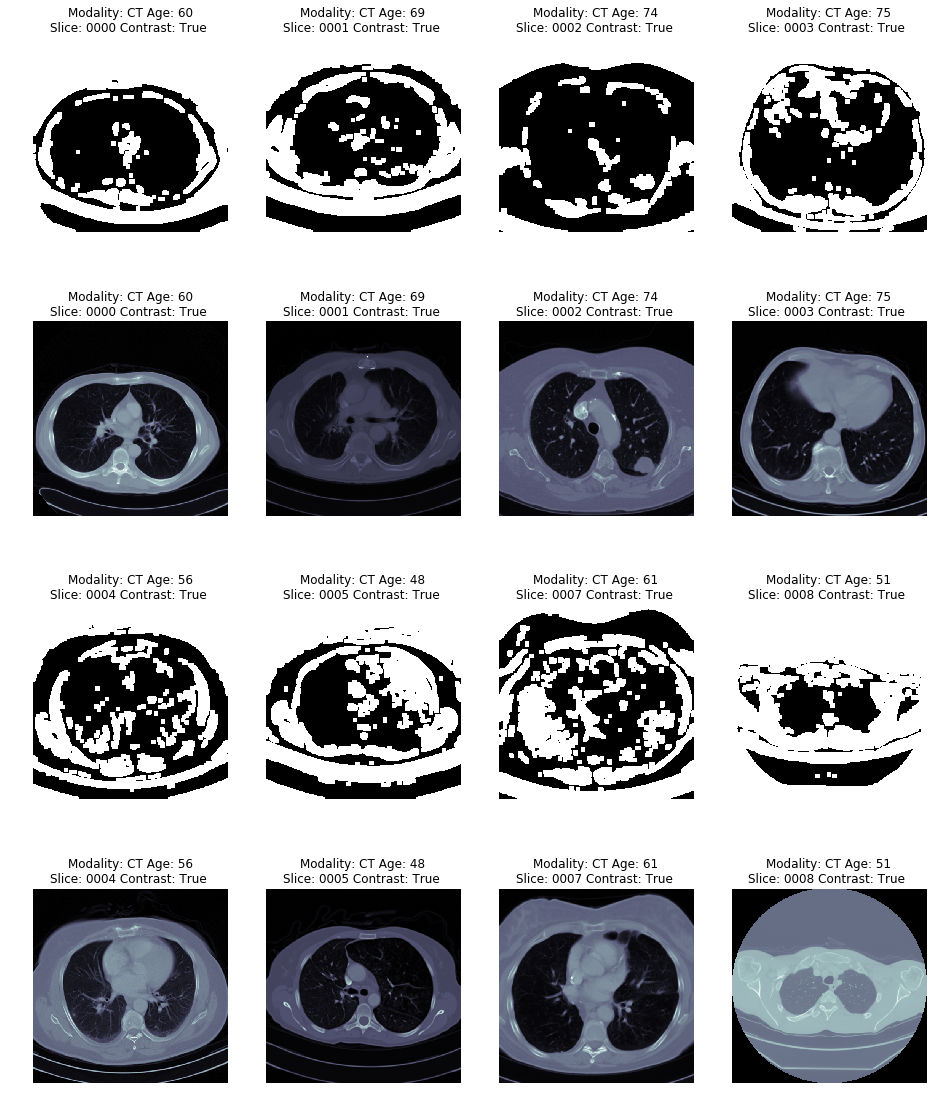

In [15]:
segementH(dicom_data,8)